In [3]:
import cv2
import os
import numpy as np
#from google.colab.patches import cv2_imshow
import time
import dlib
import os
from mtcnn.mtcnn import MTCNN
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
random.seed(99)

In [4]:
# Configuración del dataset WFD
# val_bbox_path = f"{rootpath}/WFD/wider_face_split/wider_face_split/wider_face_val_bbx_gt.txt"
# val_images = f"{rootpath}/WFD/wider_val/WIDER_val/images/"
rootpath = "/home/aldo/maestria/dist_comp_vision/"

WIDER_VAL_DIR = f"{rootpath}/WFD/wider_val/WIDER_val/images/"
# Archivo de texto con las etiquetas
WIDER_GT_FILE = f"{rootpath}/WFD/wider_face_split/wider_face_split/wider_face_val_bbx_gt.txt"
# --- FUNCIÓN PARA CALCULAR IOU (INTERSECTION OVER UNION) ---
def compute_iou(boxA, boxB):
    # box: [x, y, w, h]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

# --- CARGAR DATASET WIDER FACE ---
def load_wider_face_gt(gt_file_path):
    print("Cargando anotaciones WIDER Face...")
    with open(gt_file_path, 'r') as f:
        lines = f.readlines()
    
    dataset = {}
    i = 0
    while i < len(lines):
        file_name = lines[i].strip()
        i += 1
        if i >= len(lines): break
        try:
            num_faces = int(lines[i].strip())
        except ValueError:
             # A veces hay líneas vacías o errores de formato
            i += 1
            continue
            
        i += 1
        boxes = []
        if num_faces > 0:
            for _ in range(num_faces):
                # Formato: x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose
                coords = list(map(int, lines[i].strip().split()))
                # Nos quedamos con x, y, w, h. Ignoramos caras marcadas como invalidas si se desea
                # coords[7] es 'invalid'. Si es 1, a veces se ignora, pero para detección general lo incluimos
                boxes.append(coords[:4]) 
                i += 1
        else:
            # Pasa al siguiente si num_faces es 0 (línea "0 0 0 0 0 0...")
            i += 1
            
        dataset[file_name] = boxes
    print(f"Cargadas {len(dataset)} imágenes del dataset.")
    return dataset

# load labels
ground_truth_data = load_wider_face_gt(WIDER_GT_FILE)

rnd_keys = list(ground_truth_data.keys())
random.shuffle(rnd_keys)
ground_truth_data = {k:ground_truth_data[k] for k in rnd_keys}

confidenceThreshold = 0.5
print(f"loaded {len(ground_truth_data)} images")
print("Sample:")
for f in list(ground_truth_data.keys())[:5]:
    print(f"  {f}")

Cargando anotaciones WIDER Face...
Cargadas 3226 imágenes del dataset.
loaded 3226 images
Sample:
  24--Soldier_Firing/24_Soldier_Firing_Soldier_Firing_24_115.jpg
  35--Basketball/35_Basketball_basketballgame_ball_35_662.jpg
  45--Balloonist/45_Balloonist_Balloonist_45_369.jpg
  2--Demonstration/2_Demonstration_Demonstrators_2_244.jpg
  3--Riot/3_Riot_Riot_3_186.jpg


In [5]:
# growth memory
# import tensorflow as tf
# import os

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         print("Memoria GPU configurada para crecimiento dinámico.")
#     except RuntimeError as e:
#         print(e)

In [5]:
# --- INICIALIZACIÓN DE MODELOS ---

# 1. HAAR
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 2. MTCNN
detector_mtcnn = MTCNN()

# 3. DLIB
detector_dlib = dlib.get_frontal_face_detector()

# 4. DNN (Caffe)
# Asegúrate de que estas rutas sean correctas en tu Drive
modelFile = f'/home/aldo/maestria/dist_comp_vision/ComputerVisionDQuispe/models/res10_300x300_ssd_iter_140000.caffemodel'
configFile = '/home/aldo/maestria/dist_comp_vision/ComputerVisionDQuispe/models/deploy.prototxt'
net_dnn = cv2.dnn.readNetFromCaffe(configFile, modelFile)

I0000 00:00:1768485939.606996 2240447 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11758 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:21:00.0, compute capability: 8.6


In [6]:
# --- FUNCIONES DE DETECCIÓN ESTANDARIZADAS ---

def detect_haar(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = haar_cascade.detectMultiScale(gray, 1.1, 4)
    # HAAR ya devuelve [x, y, w, h]
    return faces if len(faces) > 0 else []

def detect_mtcnn(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector_mtcnn.detect_faces(rgb)
    # MTCNN devuelve diccionarios, extraemos 'box': [x, y, w, h]
    return [r['box'] for r in results]

def detect_dlib(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector_dlib(gray, 1) # upsample 1 vez
    boxes = []
    for r in rects:
        # Dlib devuelve rectángulos (left, top, right, bottom), convertimos a (x, y, w, h)
        boxes.append([r.left(), r.top(), r.right() - r.left(), r.bottom() - r.top()])
    return boxes

def detect_dnn(img):
    h, w = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net_dnn.setInput(blob)
    detections = net_dnn.forward()
    boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5: # Umbral de confianza
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            boxes.append([startX, startY, endX - startX, endY - startY])
    return boxes

detectors = {
    "HAAR": detect_haar,
    "MTCNN": detect_mtcnn,
    "DLIB": detect_dlib,
    "DNN": detect_dnn
}

Iniciando evaluación en 100 las imágenes...
Processing file 100...

MÉTODO     | PRECISION  | RECALL     | F1-SCORE   | TIME (s)  
HAAR       | 0.5906     | 0.1543     | 0.2447     | 0.0658
MTCNN      | 0.9440     | 0.4118     | 0.5734     | 0.6017
DLIB       | 0.9613     | 0.1138     | 0.2036     | 0.2872
DNN        | 0.9510     | 0.0741     | 0.1375     | 0.0172
Total imágenes procesadas: 100


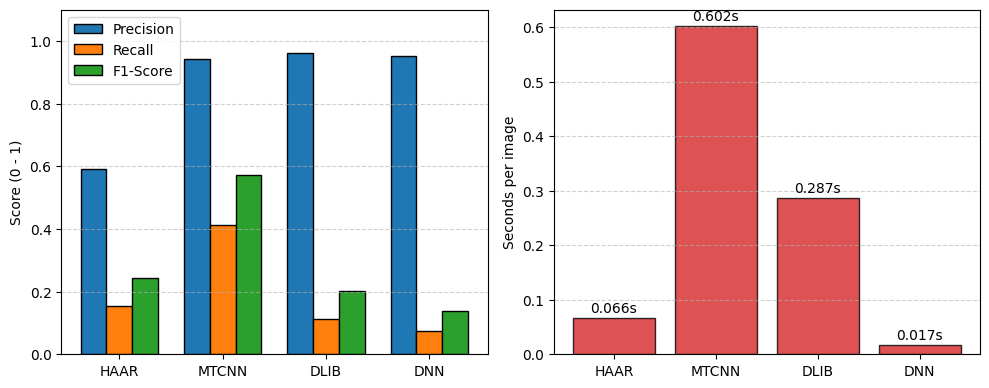

In [15]:
# --- EVALUACIÓN ---

NUM_IMAGES_TO_EVAL = 100 
IOU_THRESHOLD = 0.5

results_metrics = {name: {'TP': 0, 'FP': 0, 'FN': 0, 'Time': []} for name in detectors.keys()}

print(f"Iniciando evaluación en {NUM_IMAGES_TO_EVAL if NUM_IMAGES_TO_EVAL else 'TODAS'} las imágenes...")

count = 0
for filename, gt_boxes in ground_truth_data.items():
    if NUM_IMAGES_TO_EVAL and count >= NUM_IMAGES_TO_EVAL:
        break
    
    img_path = os.path.join(WIDER_VAL_DIR, filename)
    image = cv2.imread(img_path)
    
    if image is None:
        # print(f"No se pudo leer: {filename}") 
        continue

    count += 1
    #if count % 10 == 0: print(f"Procesando imagen {count}...")
    print(f"Processing file {count}...", end="\r")
    # cada modelo
    for name, detect_func in detectors.items():
        start_t = time.time()
        pred_boxes = detect_func(image)
        end_t = time.time()
        
        results_metrics[name]['Time'].append(end_t - start_t)

        # Calcular métricas (Matching GT vs Predicciones)
        # Copiamos las cajas para ir marcándolas como "encontradas"
        gt_copy = gt_boxes.copy()
        
        tp = 0
        fp = 0
        
        # Para cada detección, ver si coincide con algún GT
        for pred in pred_boxes:
            matched = False
            best_iou = 0
            best_gt_idx = -1
            
            for i, gt in enumerate(gt_copy):
                iou = compute_iou(pred, gt)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = i
            
            # Si el mejor IoU supera el umbral, es un TP
            if best_iou >= IOU_THRESHOLD:
                tp += 1
                # Removemos este GT para no contarlo doble
                gt_copy.pop(best_gt_idx)
            else:
                fp += 1 # Detección que no coincide con ninguna cara real
        
        # Los GT que sobraron son Falsos Negativos (caras no detectadas)
        fn = len(gt_copy)
        
        results_metrics[name]['TP'] += tp
        results_metrics[name]['FP'] += fp
        results_metrics[name]['FN'] += fn

# --- INFORME FINAL ---
print("\n\n" + "="*60)
print(f"{'MÉTODO':<10} | {'PRECISION':<10} | {'RECALL':<10} | {'F1-SCORE':<10} | {'TIME (s)':<10}")
print("="*60)

for name, res in results_metrics.items():
    tp = res['TP']
    fp = res['FP']
    fn = res['FN']
    
    # Evitar división por cero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    avg_time = np.mean(res['Time']) if res['Time'] else 0
    
    print(f"{name:<10} | {precision:.4f}     | {recall:.4f}     | {f1:.4f}     | {avg_time:.4f}")
print("="*60)
print(f"Total imágenes procesadas: {count}")


models = list(results_metrics.keys())
precision_vals = []
recall_vals = []
f1_vals = []
avg_times = []

for name in models:
    res = results_metrics[name]
    tp, fp, fn = res['TP'], res['FP'], res['FN']
    
    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0
    f = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    t = np.mean(res['Time']) if res['Time'] else 0
    
    precision_vals.append(p)
    recall_vals.append(r)
    f1_vals.append(f)
    avg_times.append(t)


x = np.arange(len(models))
width = 0.25  # bar width

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.))
ax1.bar(x - width, precision_vals, width, label='Precision', color='#1f77b4', edgecolor='black')
ax1.bar(x, recall_vals, width, label='Recall', color='#ff7f0e', edgecolor='black')
ax1.bar(x + width, f1_vals, width, label='F1-Score', color='#2ca02c', edgecolor='black')

ax1.set_ylabel('Score (0 - 1)')
#ax1.set_title('Comparativa de Rendimiento: Precision, Recall y F1', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylim(0, 1.1)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.6)

bars = ax2.bar(models, avg_times, color='#d62728', alpha=0.8, edgecolor='black')
ax2.set_ylabel('Seconds per image')
#ax2.set_title('Eficiencia Temporal (Inferencia)', fontweight='bold')
ax2.grid(axis='y', linestyle='--', alpha=0.6)


for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.3f}s', ha='center', va='bottom')

plt.tight_layout()
#plt.savefig('comparativa_modelos.png')


In [22]:
fig.savefig('comparativa_modelos.png', dpi=600)

In [9]:
colors = {
    'GT': '#00FF00',    #verde
    'HAAR': '#FF0000',  # Rojo
    'MTCNN': '#0000FF', # Azul
    'DLIB': '#FFFF00',  # Amarillo
    'DNN': '#00FFFF'    # Cian
}

def visualize_detections(dataset_gt, num_samples=4):
    #~ 4 random images
    sample_keys = random.sample(list(dataset_gt.keys()), num_samples)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for i, img_key in enumerate(sample_keys):
        img_path = os.path.join(WIDER_VAL_DIR, img_key)
        image = cv2.imread(img_path)
        if image is None: continue
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image_rgb)
        
        for box in dataset_gt[img_key]:
            x, y, w, h = box
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=colors['GT'], facecolor='none', linestyle='--')
            axes[i].add_patch(rect)

        for name, detect_func in detectors.items():
            pred_boxes = detect_func(image)
            for box in pred_boxes:
                x, y, w, h = box
                rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor=colors[name], facecolor='none')
                axes[i].add_patch(rect)
        
        axes[i].set_title(f"Muestra {i+1}: {img_key.split('/')[-1]}", fontsize=10)
        axes[i].axis('off')


    legend_elements = [
        patches.Patch(edgecolor=colors['GT'], facecolor='none', label='Ground Truth (Real)', linestyle='--', linewidth=2),
        patches.Patch(color=colors['HAAR'], label='HAAR Cascade'),
        patches.Patch(color=colors['MTCNN'], label='MTCNN'),
        patches.Patch(color=colors['DLIB'], label='DLIB (HOG)'),
        patches.Patch(color=colors['DNN'], label='DNN (SSD)')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=12, frameon=True, bbox_to_anchor=(0.5, 0.05))
    
    
    plt.tight_layout(rect=[0, 0.08, 1, 0.93])
    plt.savefig('visualizacion_benchmark.png', dpi=600)
    plt.show()
    

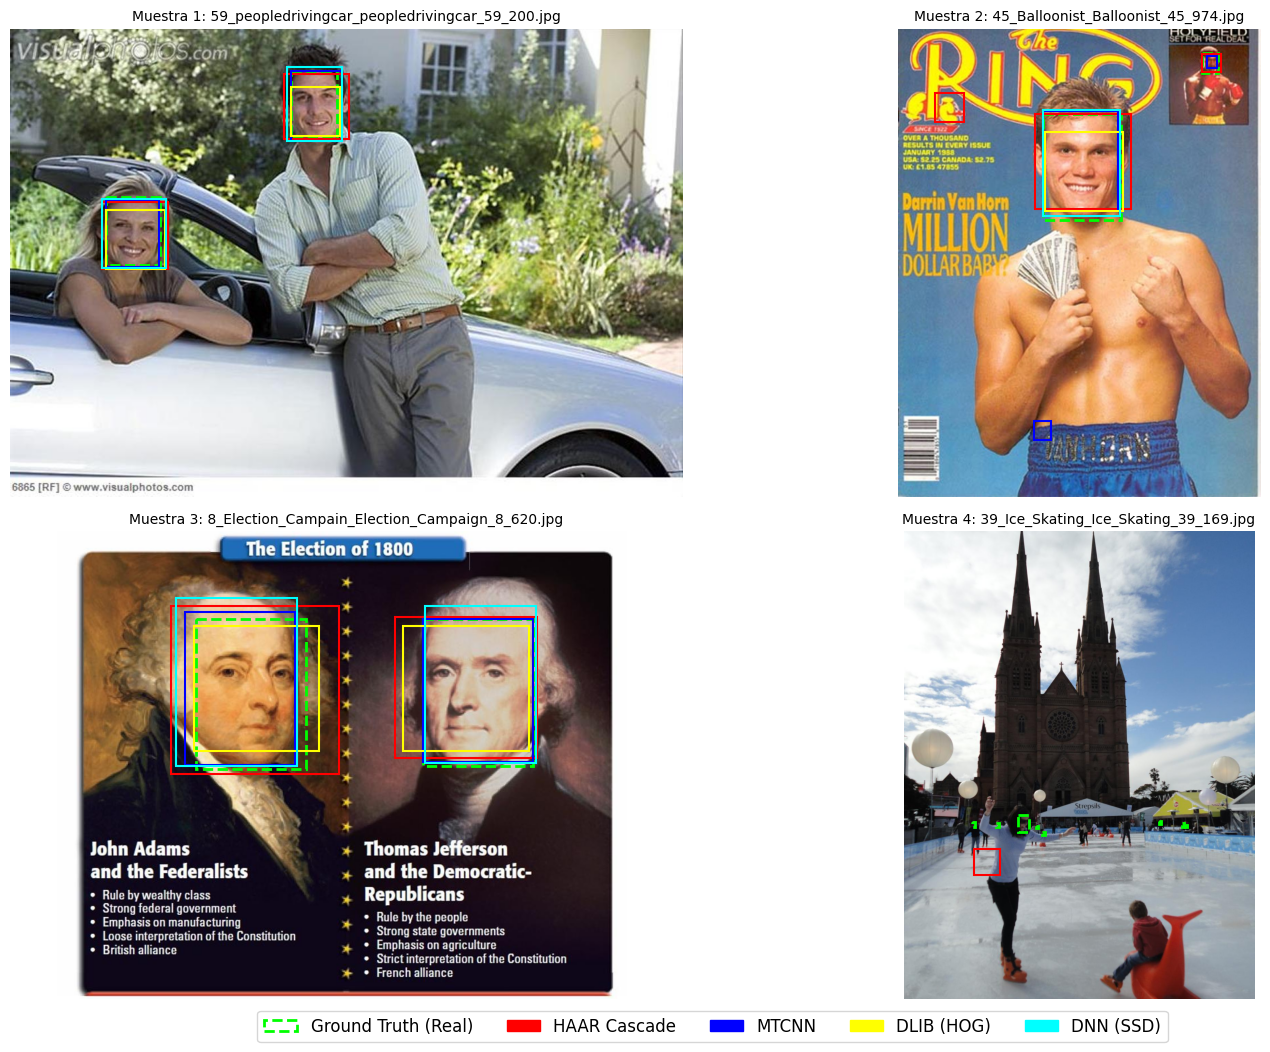

In [10]:
visualize_detections(ground_truth_data)

In [14]:
def get_size_category(height):
    if height <= 50:
        return 'Small'
    elif height <= 100:
        return 'Medium'
    else:
        return 'Large'

#  contadores
#  { 'Modelo': { 'Small': [TP, TotalGT], 'Medium': [TP, TotalGT], ... } }
categories = ['Small', 'Medium', 'Large']
size_metrics = {name: {cat: [0, 0] for cat in categories} for name in detectors.keys()}
all_gt_heights = []

print("Initializing ...")


count = 0
for filename, gt_boxes in ground_truth_data.items():
    if NUM_IMAGES_TO_EVAL and count >= NUM_IMAGES_TO_EVAL:
        break
    
    img_path = os.path.join(WIDER_VAL_DIR, filename)
    image = cv2.imread(img_path)
    if image is None: continue
    count += 1

    # Clasificar GT boxes de esta imagen y guardarlos para el histograma
    for gt in gt_boxes:
        h_gt = gt[3]
        all_gt_heights.append(h_gt)
        cat = get_size_category(h_gt)
        # Incrementar el total de GTs para esta categoría en todos los modelos
        for name in detectors.keys():
            size_metrics[name][cat][1] += 1

    # for each model
    for name, detect_func in detectors.items():
        pred_boxes = detect_func(image)
        gt_copy = [ (box, get_size_category(box[3])) for box in gt_boxes ]
        
        for pred in pred_boxes:
            best_iou = 0
            best_gt_idx = -1
            
            for idx, (gt_box, cat) in enumerate(gt_copy):
                iou = compute_iou(pred, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            
            if best_iou >= IOU_THRESHOLD:
                # if match +1 TP
                matched_cat = gt_copy[best_gt_idx][1]
                size_metrics[name][matched_cat][0] += 1
                gt_copy.pop(best_gt_idx)

Initializing ...


KeyboardInterrupt: 

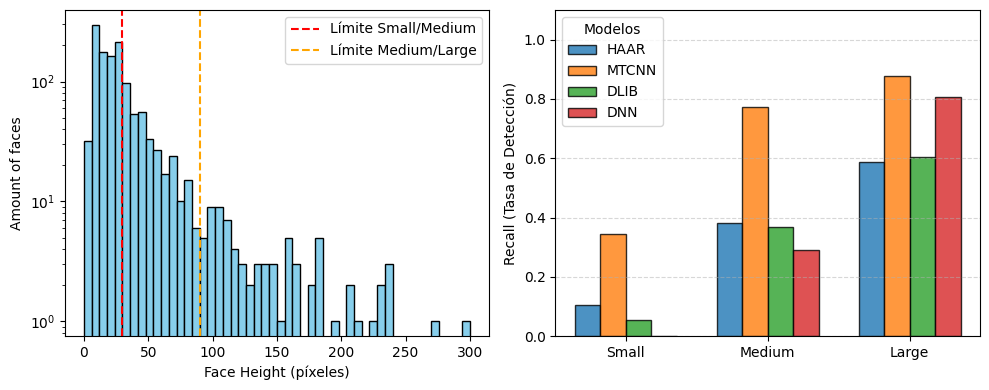


RESUMEN DE RECALL POR CATEGORÍA:
HAAR    : Small: 10.5% | Medium: 38.3% | Large: 58.9% | 
MTCNN   : Small: 34.6% | Medium: 77.3% | Large: 87.7% | 
DLIB    : Small: 5.5% | Medium: 36.7% | Large: 60.3% | 
DNN     : Small: 0.1% | Medium: 28.9% | Large: 80.8% | 


In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# GRAFICO 1: Distribución General del Dataset
ax1.hist(all_gt_heights, bins=50, color='skyblue', edgecolor='black', range=(0, 300))
ax1.axvline(30, color='red', linestyle='--', label='Límite Small/Medium')
ax1.axvline(90, color='orange', linestyle='--', label='Límite Medium/Large')
#ax1.set_title('Distribución de Tamaños de Rostros (Ground Truth)', fontweight='bold')
ax1.set_yscale("log")
ax1.set_xlabel('Face Height (píxeles)')
ax1.set_ylabel('Amount of faces')
ax1.legend()

x = np.arange(len(categories))
width = 0.18

for i, (model_name, metrics) in enumerate(size_metrics.items()):
    recalls = []
    for cat in categories:
        tp, total = metrics[cat]
        recalls.append(tp / total if total > 0 else 0)
    
    offset = (i - len(detectors)/2) * width + width/2
    ax2.bar(x + offset, recalls, width, label=model_name, edgecolor='black', alpha=0.8)

ax2.set_ylabel('Recall (Tasa de Detección)')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1.1)
ax2.legend(title="Modelos")
ax2.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('analisis_por_tamano.png', dpi=300)
plt.show()

print("\nRESUMEN DE RECALL POR CATEGORÍA:")
for model in size_metrics:
    row = f"{model:<8}: "
    for cat in categories:
        tp, tot = size_metrics[model][cat]
        rate = (tp/tot)*100 if tot > 0 else 0
        row += f"{cat}: {rate:.1f}% | "
    print(row)